In [194]:

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
from IPython.display import display_html
from networkx.algorithms import community
from collections import defaultdict

#helper function
def display_side_by_side(dfs, titles=None):
    html_str = "<div style='display:flex;flex-flow:row nowrap;column-gap:20px'>"
    for df, title in zip(dfs, titles):
        html_str += f"""
        <div style="margin:10px">
            <h4 style="text-align:center">{title}</h4>
            {df.to_html()}
        </div>"""
    html_str += "</div>"

    display_html(html_str, raw=True)

def top_n_degrees(degree_dict: dict, n: int) -> pd.DataFrame:
    df = pd.DataFrame(list(degree_dict.items()), columns=["Node", "Degree"])
    df["Degree_(%)"] = (df["Degree"] / df["Degree"].sum()) * 100


    df = df.sort_values(by="Degree", ascending=False).head(n).reset_index(drop=True)
    return df.style.hide(axis="index")



# Global nematode–mammal interactions (2018)


A global interaction web of interactions between nematodes and their host mammal species,


In [147]:
mamal_df = pd.read_csv(filepath_or_buffer="mammal_nematode/edges.csv")
metadata = pd.read_csv("mammal_nematode/nodes.csv")
metadata.columns = metadata.columns.str.strip().str.replace('#', '').str.replace(' ', '_')


In [148]:
animal_map = {1:"host",0:"parasite"}
metadata["organism"] =  metadata["is_host"].map(animal_map)

In [149]:
metadata.head()

,_index,name,full_name,locality,group,is_host,_pos,organism
0,0,Squalus blainville,"Proleptus robustus (van Beneden, 1871)",Northeast Atlantic,Nematoda,1,"array([32.67422356, 46.0460785 ])",host
1,1,Acanthocephaloides incrassatus,NaN,NaN,Teleostei,0,"array([39.44431659, 25.20409242])",parasite
2,2,Gobius bucchichi,Deretrema (Spinoderetrema) scorpaenicola Barto...,Western Mediterranean,Trematoda,1,"array([43.9399518 , 28.96108572])",host
3,3,Acanthocephaloides propinquus,NaN,NaN,Teleostei,0,"array([37.69593368, 27.68332545])",parasite
4,4,Gobius cruentatus,"Acanthocephaloides propinquus (Dujardin, 1845)",Atlantic Ocean,Acanthocephala,1,"array([30.49701772, 30.25827091])",host


In [150]:
host_nodes = metadata[metadata["organism"] == "host"]["_index"].to_list()
parasite_nodes = metadata[metadata["organism"] != "host"]["_index"].to_list()
GN = nx.Graph()
GN.add_nodes_from(host_nodes,bipartite = 1)
GN.add_nodes_from(parasite_nodes,bipartite = 0)
GN.add_edges_from(list(mamal_df.itertuples(index=False, name=None)))

In [151]:
bipartite.is_bipartite(GN)

True

In [209]:
node_colors = {}
for node,data in GN.nodes(data=True):
    data["name"] = (metadata[metadata["_index"] == node]).iloc[0]["name"]
    organism = (metadata[metadata["_index"] == node]).iloc[0]["organism"]
    data["organism"] = organism
    node_colors[node]= "tomato" if organism == "host" else "skyblue"
    # print(node,data)


In [201]:

def get_island_graph_components(G, threshold=3, remove_unconnected=False):
    strong_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] >= threshold]
    island_graph = nx.Graph()
    island_graph.add_edges_from(strong_edges)

    if remove_unconnected:
        island_graph.remove_nodes_from(list(nx.isolates(island_graph)))

    components = [island_graph.subgraph(c).copy() for c in nx.connected_components(island_graph)]
    components.sort(key=lambda x: x.number_of_nodes(), reverse=True)

    return island_graph, components


def plot_island_graph(G,threshold, node_size=400):
    if G.number_of_edges() == 0:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No edges to plot", ha="center", va="center")
        ax.axis("off")
        return fig

    pos = nx.kamada_kawai_layout(G)
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    widths = [w / max(weights) * 4 for w in weights] if weights else 1

    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw(
        G,
        pos,
        node_color="skyblue",
        edge_color="gray",
        width=widths,
        node_size=node_size,
        with_labels=True,
        font_size=8,
        ax=ax
    )
    ax.axis("off")
    ax.set_title(f"Island Graph (edges weight ≥ {threshold})")
    


def analyze_island_metrics(G, top_n=10, graph_label="Island Graph"):
    avg_clustering = nx.average_clustering(G)
    avg_weighted_clustering = nx.average_clustering(G, weight="weight")
    density = nx.density(G)

    clustering_summary = pd.DataFrame(
        [[avg_clustering, avg_weighted_clustering, density]],
        columns=["Average Clustering", "Weighted Average Clustering", "Density"]
    )

    deg_centrality = nx.degree_centrality(G)
    bet_centrality = nx.betweenness_centrality(G)
    eig_centrality = nx.eigenvector_centrality(G)

    top_degree = top_n_degrees(deg_centrality, top_n)
    top_betweenness = top_n_degrees(bet_centrality, top_n)
    top_eigen = top_n_degrees(eig_centrality, top_n)

    display_side_by_side(
        [clustering_summary, top_degree, top_betweenness, top_eigen],
        [f"{graph_label} Metrics", "Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
    )


def analyze_connectivity(G, graph_label="Graph"):
    articulation_points = list(nx.articulation_points(G))
    bridges = list(nx.bridges(G))

    summary = pd.DataFrame({
        "Metric": ["Articulation Points", "Bridges"],
        "Count": [len(articulation_points), len(bridges)],
        "Details": [
            articulation_points if articulation_points else "None",
            bridges if bridges else "None"
        ]
    })

    summary.index = [f"{graph_label} - {m}" for m in summary["Metric"]]
    # summary.drop(columns=["Metric"], inplace=True)

    return summary.style.hide(axis="index")



def summarize_core_numbers(G, top_n=None):
    core_numbers = nx.core_number(G)
    core_groups = defaultdict(list)

    for node, core_val in core_numbers.items():
        core_groups[core_val].append(node)

    # Sort by core number descending (deepest core first)
    core_items = sorted(core_groups.items(), reverse=True)

    if top_n is not None:
        core_items = core_items[:top_n]

    df = pd.DataFrame([
        {"Core Number": k, "Node Count": len(v), "Nodes": sorted(v)}
        for k, v in core_items
    ])

    return df.style.hide(axis="index")


## Host Nodes

In [154]:
host_graph = bipartite.weighted_projected_graph(GN,set(host_nodes))

In [155]:
weights = nx.get_edge_attributes(host_graph, 'weight')
max_weight = max(weights.values())
max_weight

76

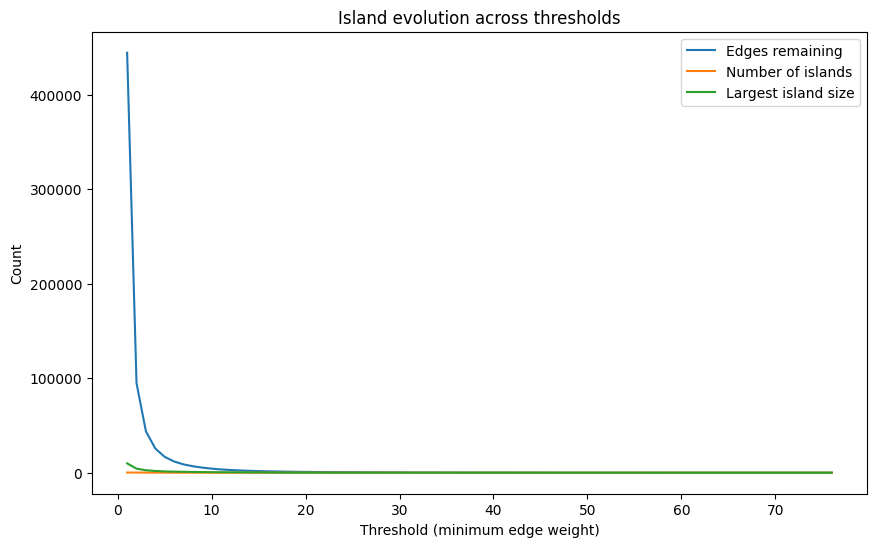

In [156]:
weights = [d['weight'] for _, _, d in host_graph.edges(data=True)]
min_w, max_w = min(weights), max(weights)

thresholds = range(1, max_w + 1)
edges_count, comps_count, largest_size = [], [], []

for t in thresholds:
    sub_edges = [(u, v) for u, v, d in host_graph.edges(data=True) if d['weight'] >= t]
    subG = host_graph.edge_subgraph(sub_edges).copy()
    edges_count.append(subG.number_of_edges())
    comps = list(nx.connected_components(subG))
    comps_count.append(len(comps))
    largest_size.append(max(len(c) for c in comps) if comps else 0)

plt.figure(figsize=(10,6))
plt.plot(thresholds, edges_count, label="Edges remaining")
plt.plot(thresholds, comps_count, label="Number of islands")
plt.plot(thresholds, largest_size, label="Largest island size")
plt.xlabel("Threshold (minimum edge weight)")
plt.ylabel("Count")
plt.title("Island evolution across thresholds")
plt.legend()
plt.show()

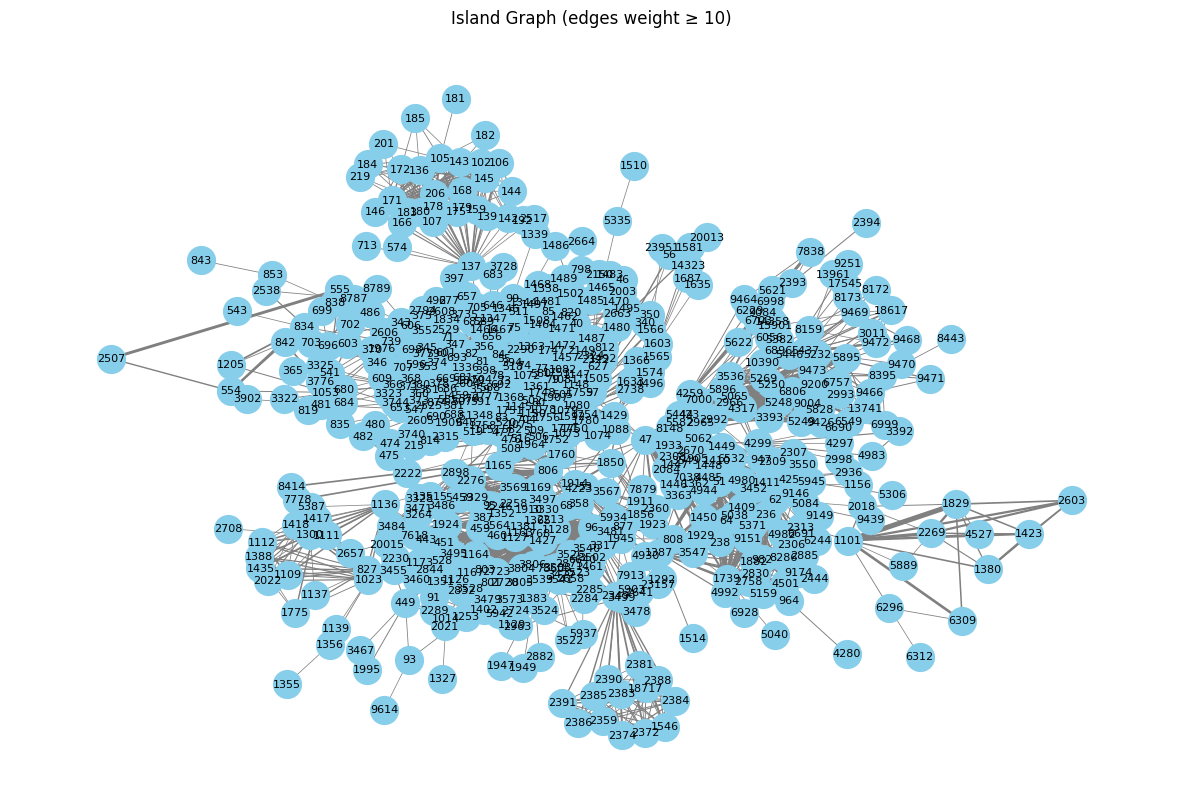

In [234]:

host_graph_10, comps = get_island_graph_components(host_graph, threshold=10, remove_unconnected=True)
host_graph_10_comp = comps[0]
plot_island_graph(comps[0],10)

In [238]:
len(comps)


39

In [ ]:
# for a in list(comps):
#     print(len(list(a)))

592
22
15
14
10
8
7
6
6
5
4
4
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [214]:
analyze_island_metrics(host_graph_10_comp, top_n=10, graph_label="Island ≥10")




Island ≥10 Metrics 
 
 
 
 
 Average Clustering 
 Weighted Average Clustering 
 Density 
 
 
 
 
 0 
 0.659819 
 0.139759 
 0.023249 
 
 
 
 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 80 
 0.164129 
 1.192525 
 
 
 398 
 0.148900 
 1.081879 
 
 
 73 
 0.143824 
 1.044996 
 
 
 55 
 0.143824 
 1.044996 
 
 
 519 
 0.140440 
 1.020408 
 
 
 520 
 0.135364 
 0.983526 
 
 
 692 
 0.130288 
 0.946644 
 
 
 356 
 0.130288 
 0.946644 
 
 
 379 
 0.128596 
 0.934350 
 
 
 394 
 0.120135 
 0.872879 
 
 
 

 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 47 
 0.410507 
 13.243407 
 
 
 1080 
 0.195843 
 6.318100 
 
 
 806 
 0.177040 
 5.711497 
 
 
 356 
 0.169174 
 5.457727 
 
 
 96 
 0.131427 
 4.239966 
 
 
 137 
 0.103361 
 3.334545 
 
 
 519 
 0.095288 
 3.074104 
 
 
 2276 
 0.092768 
 2.992787 
 
 
 57 
 0.091379 
 2.947991 
 
 
 80 
 0.070861 
 2.286053 
 
 
 

 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 398 
 0.191043 
 1.828779 
 
 
 80 
 0.187484 
 1.794707 
 
 
 519 
 0.183341 
 1.755053 
 
 
 73 
 0.180357 
 1.726486 
 
 
 55 
 0.179490 
 1.718193 
 
 
 520 
 0.175941 
 1.684212 
 
 
 504 
 0.170730 
 1.634332 
 
 
 692 
 0.170423 
 1.631392 
 
 
 394 
 0.161725 
 1.548132 
 
 
 518 
 0.152668 
 1.461429

Plac

In [215]:
connectivity_10 = analyze_connectivity(host_graph_10_comp, graph_label="Island ≥10")
connectivity_10



Metric,Count,Details
Articulation Points,62,"[508, 3744, 374, 481, 834, 853, 838, 739, 366, 345, 1566, 1603, 1760, 3806, 1924, 460, 1014, 93, 449, 1300, 1023, 1356, 1383, 5934, 20015, 387, 2349, 806, 96, 6296, 2393, 423, 8395, 5437, 5896, 7000, 3536, 425, 1739, 1411, 1387, 238, 964, 4299, 62, 4259, 47, 1080, 99, 394, 5335, 1465, 1457, 77, 547, 74, 379, 57, 105, 137, 356, 820]"
Bridges,85,"[(356, 137), (356, 683), (356, 3728), (379, 480), (547, 835), (74, 1468), (77, 1502), (820, 2664), (1457, 1470), (1457, 1483), (1457, 1495), (1457, 2003), (47, 4259), (47, 5444), (47, 5582), (47, 8148), (57, 350), (62, 9439), (96, 2641), (96, 3478), (238, 6928), (423, 2393), (425, 5306), (806, 4223), (806, 3481), (1080, 2738), (1387, 1514), (1411, 1156), (1739, 5040), (3536, 5621), (3536, 6998), (4259, 6229), (4299, 2998), (4299, 4297), (4299, 6690), (5896, 6703), (5934, 23157), (7000, 5622), (394, 397), (508, 2222), (374, 486), (99, 1339), (1465, 5335), (93, 9614), (449, 3467), (449, 1995), (387, 20015), (460, 1402), (460, 2832), (460, 5942), (1383, 1947), (1383, 1949), (3806, 2882), (1924, 2657), (105, 181), (137, 192), (137, 2517), (137, 574), (137, 713), (964, 4280), (345, 8789), (366, 3325), (3744, 819), (739, 838), (20015, 20013), (2393, 2394), (1014, 1327), (1023, 1139), (1023, 1356), (481, 3902), (543, 834), (838, 853), (1300, 2708), (853, 843), (1356, 1355), (1566, 23951), (1603, 1581), (1603, 1635), (1603, 1687), (1603, 14323), (6296, 6312), (5335, 1510), (5437, 13961), (5437, 8173), (8395, 8443)]"


In [212]:
core_summary_top10 = summarize_core_numbers(host_graph_10_comp, top_n=10)
core_summary_top10


Core Number,Node Count,Nodes
84,102,"[5, 71, 73, 74, 81, 82, 83, 106, 137, 343, 345, 346, 347, 351, 353, 355, 356, 359, 360, 365, 366, 367, 368, 370, 371, 373, 374, 375, 377, 378, 379, 380, 398, 492, 504, 507, 519, 541, 547, 574, 580, 588, 589, 590, 591, 596, 601, 603, 606, 609, 653, 655, 656, 657, 660, 676, 680, 681, 683, 684, 686, 688, 690, 692, 693, 698, 705, 707, 739, 814, 819, 835, 874, 1336, 1834, 1879, 1976, 2512, 2514, 2517, 2525, 2529, 2537, 2604, 2605, 2794, 3323, 3325, 3672, 3728, 3735, 3744, 3745, 3799, 3941, 4188, 5728, 5731, 8646, 8789, 8841, 10177]"
82,4,"[47, 677, 713, 2538]"
81,9,"[57, 336, 394, 664, 669, 704, 1053, 2433, 2531]"
80,4,"[696, 699, 10176, 10545]"
79,3,"[701, 702, 703]"
78,1,[2162]
77,2,"[685, 3798]"
75,5,"[479, 481, 486, 558, 6106]"
74,4,"[485, 489, 3776, 10636]"
73,3,"[520, 682, 10142]"


## Events


In [464]:
club_weighted = bipartite.weighted_projected_graph(G, clubs)
club_unweighted = bipartite.projected_graph(G, clubs)

for u, v, d in club_weighted.edges(data=True):
    d["inv_weight"] = 1 / d["weight"]

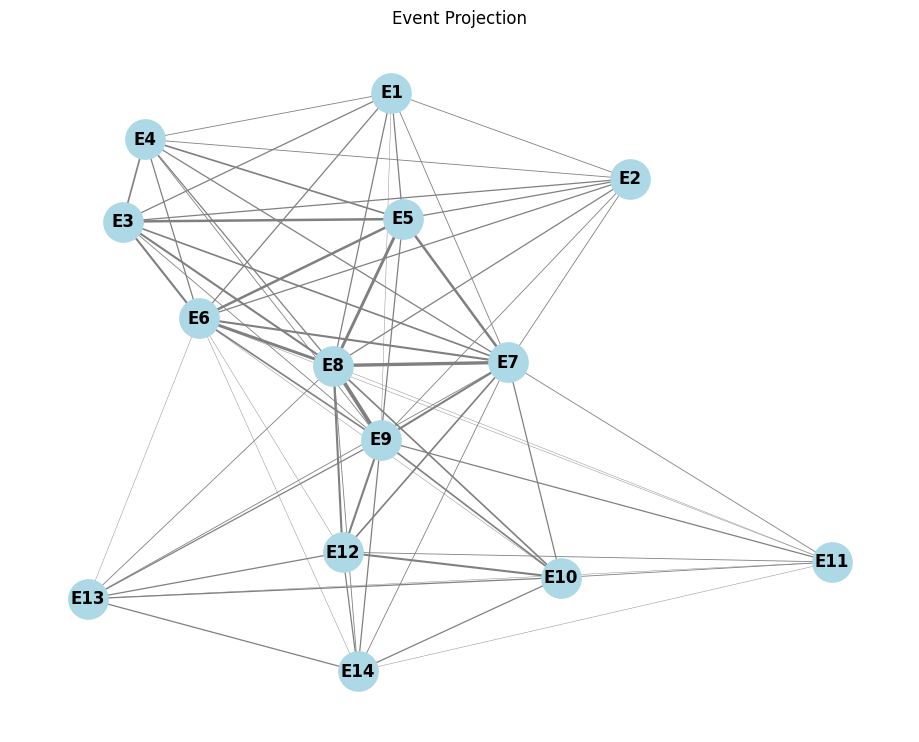

In [465]:
pos = nx.spring_layout(club_weighted, seed=42)
edge_weights = [club_weighted[u][v]["weight"] for u, v in club_weighted.edges()]

plt.figure(figsize=(9, 7))
nx.draw(
    club_weighted,
    pos,
    with_labels=True,
    node_color="lightblue",
    node_size=800,
    font_weight="bold",
    edge_color="gray",
    width=[w * 0.3 for w in edge_weights]
)
plt.title("Event Projection")
plt.show()

In [466]:
# Compute clustering and density metrics for the club projection
avg_clustering_club = nx.average_clustering(club_weighted)
avg_weighted_clustering_club = nx.average_clustering(club_weighted, weight="inv_weight")
club_density = nx.density(club_weighted)

# Create a summary DataFrame
clustering_metrics_club = pd.DataFrame(
    data=[[avg_clustering_club, avg_weighted_clustering_club, club_density]],
    columns=["Average Clustering", "Weighted Average Clustering", "Density"]
)

clustering_metrics_club.style.hide(axis="index")


Average Clustering,Weighted Average Clustering,Density
0.908425,0.345002,0.725275


The results show that most clubs are well connected, but the strength of those connections is not the same across the network. The **average clustering coefficient of 0.91** means that many clubs share participants with several others, forming close groups where members often attend multiple events together. When the strength of these shared connections is considered, the **weighted clustering coefficient drops to 0.35**, showing that some ties are much stronger than others. This means that while most clubs are linked, only a few share participants frequently. The **density of 0.73** supports this pattern, showing that the network is generally connected but not all clubs are linked with equal intensity. Overall, the club network shows broad participation with a few strong overlaps and many lighter connections between events.


In [467]:
# Unweighted metrics
degree_centrality = nx.degree_centrality(club_unweighted)
betweenness_centrality = nx.betweenness_centrality(club_unweighted)
eigen_centrality = nx.eigenvector_centrality(club_unweighted)

# Weighted metrics
weighted_degree = dict(club_weighted.degree(weight="weight"))
weighted_betweenness = nx.betweenness_centrality(club_weighted, weight="inv_weight")
weighted_eigen = nx.eigenvector_centrality(club_weighted, weight="weight")

In [468]:
club_degree_top = top_n_degrees(degree_centrality, 10)
club_betweenness_top = top_n_degrees(betweenness_centrality, 10)
club_eigen_top = top_n_degrees(eigen_centrality, 10)

display_side_by_side(
    [club_degree_top, club_betweenness_top, club_eigen_top],
    ["Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
)

Node,Degree,Degree_(%)
E6,1.000000,9.848485
E7,1.000000,9.848485
E8,1.000000,9.848485
E9,1.000000,9.848485
E2,0.615385,6.060606
E1,0.615385,6.060606
E5,0.615385,6.060606
E4,0.615385,6.060606
E3,0.615385,6.060606
E10,0.615385,6.060606


The unweighted centrality results show that a few clubs occupy a much more prominent structural position in the network. Clubs E6, E7, E8, and E9 have the highest degree, betweenness, and eigenvector centrality values, indicating that they are strongly interconnected and share attendees with almost every other club. These clubs likely represent the most active or socially central gatherings where participation overlaps extensively. The remaining clubs (E1–E5 and E10–E14) have lower scores across all measures, suggesting they attract smaller or more distinct groups of participants.

In [469]:
club_w_degree_top = top_n_degrees(weighted_degree, 10)
club_w_betweenness_top = top_n_degrees(weighted_betweenness, 10)
club_w_eigen_top = top_n_degrees(weighted_eigen, 10)

display_side_by_side(
    [club_w_degree_top, club_w_betweenness_top, club_w_eigen_top],
    ["Weighted Degree Centrality", "Weighted Betweenness Centrality", "Weighted Eigenvector Centrality"]
)


Node,Degree,Degree_(%)
E8,59,13.785047
E7,48,11.214953
E9,46,10.747664
E6,41,9.579439
E5,38,8.878505
E3,32,7.476636
E12,28,6.542056
E10,25,5.841121
E4,23,5.373832
E2,20,4.672897


The weighted results show clearer differences between clubs, helping to identify which ones attract the most shared participation. **Club E8** has the highest values across all metrics, meaning it shares the most attendees with other clubs, connects different parts of the network, and is linked to other popular gatherings. **Clubs E7, E9, and E6** also have high scores for degree and eigenvector centrality, showing they are part of the same core group of closely related events. The weighted betweenness results, however, reveal that only E8 and E9 serve as real bridges between different sets of clubs, while most others stay connected within their own circles.

In [ ]:
club_communities = community.greedy_modularity_communities(club_weighted, weight="weight")

club_community_data = []

for i, comm in enumerate(club_communities, start=1):
    club_community_data.append({
        "Community": f"Community {i}",
        "Members": ", ".join(sorted(comm)),
        "Size": len(comm)
    })

club_community_df = pd.DataFrame(club_community_data)

club_community_df.style.hide(axis="index")


Community,Members,Size
Community 1,"E1, E2, E3, E4, E5, E6, E7, E8",8
Community 2,"E10, E11, E12, E13, E14, E9",6


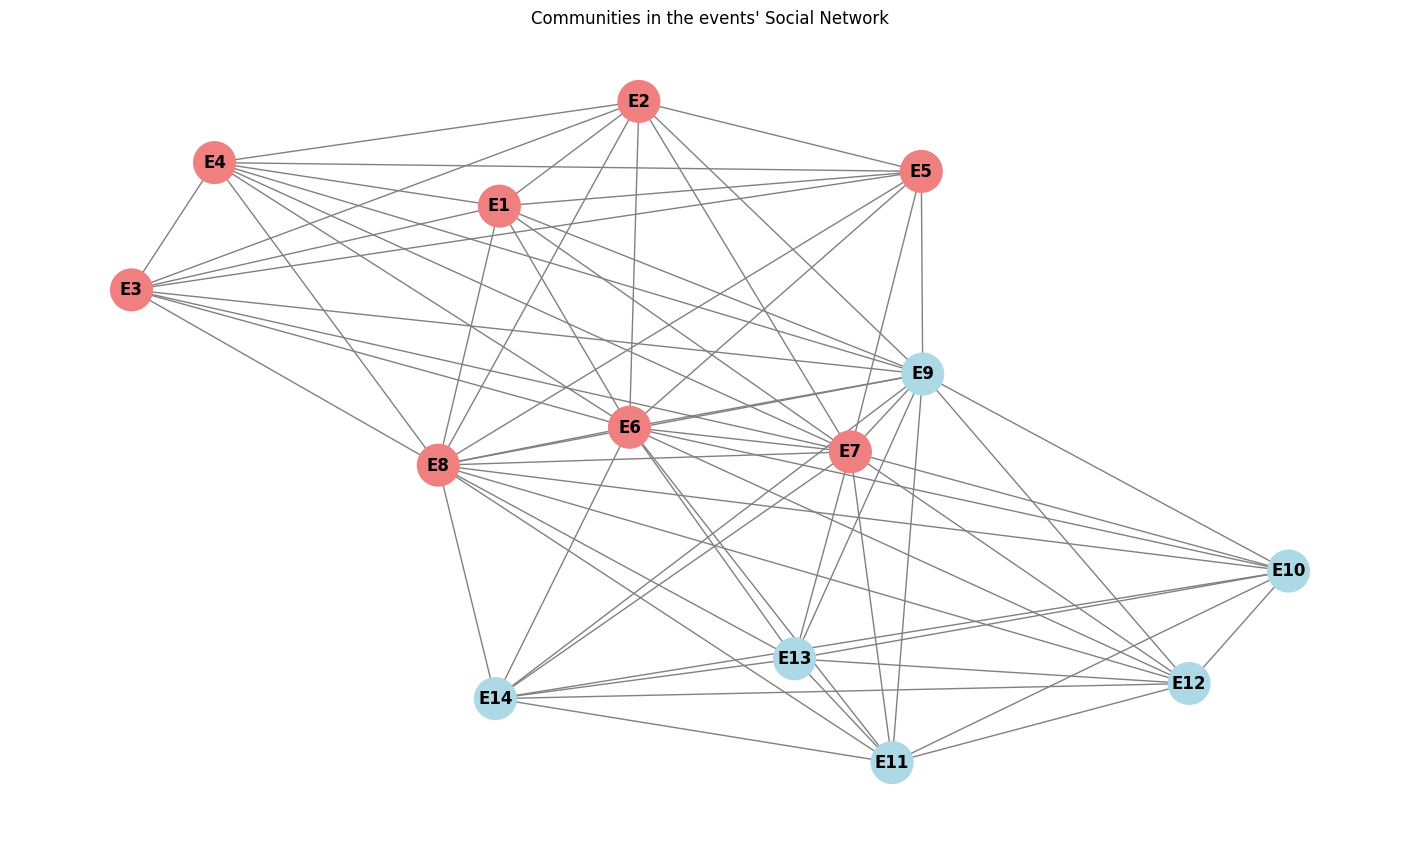

In [471]:
color_map_event = {}
colors = ['lightcoral', 'lightblue', 'lightgreen']
for i, comm in enumerate(club_communities):
    for node in comm:
        color_map_event[node] = colors[i % len(colors)]

node_colors_club = [color_map_event[n] for n in club_unweighted.nodes()]

plt.figure(figsize=(14, 8))
pos = nx.spring_layout(club_unweighted, seed=42)
nx.draw(club_unweighted, pos,
        with_labels=True,
        node_color=node_colors_club,
        edge_color='gray',
        node_size=900,
        font_weight='bold')
plt.title("Communities in the events' Social Network")
plt.show()

The community detection results show two main groups of clubs that attract different but overlapping sets of participants. **Community 1**, which includes clubs E1 through E8, represents the most interconnected group, where events tend to share many of the same attendees. Several of these clubs, such as **E6**, **E7**, and **E8**, are also among the most central according to the previous metrics, suggesting that this cluster forms the **core** of the social activity network. **Community 2**, made up of clubs **E9** through **E14**, appears more peripheral but still linked to the main group through shared participants, particularly via **Club E9**, which acts as a connector between both communities. Together, these results suggest that participation in social events is organized around one large and cohesive cluster of closely related clubs, with a smaller secondary group that interacts with it through a few key bridging events.

In [487]:
event_cliques = list(nx.find_cliques(club_weighted))
event_clique_data = [{"Size": len(c), "Members": ", ".join(sorted(c))} for c in event_cliques]
event_clique_df = pd.DataFrame(event_clique_data).sort_values(by="Size", ascending=False)
event_clique_df.style.hide(axis="index")





Size,Members
9,"E10, E11, E12, E13, E14, E6, E7, E8, E9"
9,"E1, E2, E3, E4, E5, E6, E7, E8, E9"


The clique analysis shows that there are two large, fully connected groups of clubs. Each clique contains nine events, and they overlap through **Clubs E6 to E9**, which appear in both groups. This pattern suggests that these clubs share many of the same participants and serve as strong links between the two main clusters of events.

In [510]:
event_articulation_points = list(nx.articulation_points(club_weighted))
event_bridges = list(nx.bridges(club_weighted))

event_connectivity_summary = pd.DataFrame({
    "Metric": ["Articulation Points", "Bridges"],
    "Count": [len(event_articulation_points), len(event_bridges)],
    "Details": [event_articulation_points if event_articulation_points else "None",
                event_bridges if event_bridges else "None"]
})

event_connectivity_summary.style.hide(axis="index")



Metric,Count,Details
Articulation Points,0,None
Bridges,0,None


 The lack of articulation points or bridges means that no single club or connection is critical to keeping the network connected. Even if one event or link were removed, the rest of the network would remain fully joined. Overall, the event network shows high cohesion and redundancy, with multiple overlapping connections ensuring its stability.


In [495]:
event_core_numbers = nx.core_number(club_weighted)
event_max_core = nx.k_core(club_weighted)

event_kcore_df = (
    pd.DataFrame(data=list(event_core_numbers.items()), columns=["Event", "Core"])
    .sort_values("Core", ascending=False)

)

In [499]:
matrix_df_event = (
    event_kcore_df
    .set_index('Event')     
    .T                      
    .rename_axis(None, axis=0)  
    .rename_axis('Event', axis=1) 
)

matrix_df_event.index = ['Core']
matrix_df_event


Event,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14
Core,8,8,8,8,8,8,8,8,8,8,8,8,8,8


The k-core analysis shows that all events belong to the same highest-order core, where each club is connected to at least eight others within this inner structure. This means that the event network is uniformly dense, with no peripheral or weakly linked clubs. Every event contributes to the same cohesive core, confirming that participation patterns are evenly distributed across the network. Combined with the absence of articulation points or bridges and the presence of large overlapping cliques, this result shows a highly stable and resilient event network where all gatherings are strongly connected through shared participants.

## Conclusion

The analysis of the Davis Southern Women network shows that the group was very cohesive and well connected. The data link 18 women and 14 events through shared attendance, forming a dense web of relationships. In the unweighted results, almost every woman was connected, with an average clustering coefficient of **0.94** and a density of **0.91**. This means that if two women attended an event with a third, they were very likely connected as well. **Evelyn Jefferson**, **Theresa Anderson**, **Sylvia Avondale**, and **Ruth DeSand** attended the most events and had the highest centrality values, while **Myra Liddel** and **Laura Mandeville** also participated actively but had slightly fewer connections. Influence was shared across many members, showing a balanced and inclusive social setting.

When the strength of connections was considered, the weighted clustering coefficient dropped to **0.49**, which suggests that while the network remained dense, not all relationships were equally strong. The same women stayed central, but **Theresa Anderson** and **Nora Fayette** became especially important as they linked different parts of the network. The weighted results showed that a few participants maintained stronger and more frequent ties that helped keep the network connected.

The community analysis identified **three main groups**.  
- **Group 1:** Included Theresa Anderson, Evelyn Jefferson, and Ruth DeSand. This was the most active and central group.  
- **Group 2:** Contained women such as Laura Mandeville and Brenda Rogers, who had strong internal links but fewer ties to others.  
- **Group 3:** Included Nora Fayette and Sylvia Avondale, who were smaller and more peripheral but sometimes acted as connectors.  

The absence of articulation points and bridges showed that no single woman was essential for the network’s stability. The **k-core result** confirmed that most women belonged to a tightly connected inner group of **14 members**, with only a few being less connected.

The **event network** showed a similar pattern. **Clubs E6, E7, E8, and E9** were the most central and shared attendees with nearly all other clubs. The weighted results highlighted **E8** and **E9** as the main bridges connecting two event communities: one containing **Clubs E1–E8** and the other **E9–E14**. The large overlapping cliques and the lack of articulation points or bridges showed that the network of events was stable and evenly connected, with every event linked to at least eight others.

Overall, both the women’s and event networks were **cohesive, stable, and resilient**. The unweighted results showed broad participation, while the weighted results revealed that a few individuals and events, such as **Theresa Anderson**, **Nora Fayette**, and **Clubs E8 and E9**, played key roles in keeping the network united. These findings describe a community where participation was widespread, supported by a small core of highly active members and gatherings that helped maintain strong connections throughout the group.

